In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from cnp.data import GPGenerator

from cnp.cnp import StandardGNP, StandardAGNP, StandardConvGNP, FullConvGNP
from cnp.cov import InnerProdCov, KvvCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno
from shutil import copyfile

from collections import OrderedDict

from itertools import product

import matplotlib
# matplotlib.rcParams['text.usetex'] = True

In [2]:
def eq_cov(lengthscale, coefficient, noise):
    
    def _eq_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l2 = torch.sum((diff / lengthscale) ** 2, dim=2)
        cov = coefficient ** 2 * np.exp(-0.5 * l2)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    
    return _eq_cov


def mat_cov(lengthscale, coefficient, noise):
    
    def _mat_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l1 = torch.sum(np.abs(diff / lengthscale), dim=2)
        cov = coefficient ** 2 * (1 + 5 ** 0.5 * l1 + 5 * l1 ** 2 / 3)
        cov = cov * np.exp(- 5 ** 0.5 * l1)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    return _mat_cov


def wp_cov(period, lengthscale, coefficient, noise):
    
    def _wp_cov(x, x_, use_noise):
    
        diff = x[:, None, :] - x_[None, :, :]
        l1 = torch.sum(np.abs(diff / period), dim=2)
        l2 = torch.sum((diff / lengthscale) ** 2, dim=2)
        
        sin2 = (torch.sin(np.pi * l1) / lengthscale) ** 2
        
        cov = coefficient ** 2 * torch.exp(-2. * sin2)
        cov = cov * np.exp(-0.5 * l2)
        
        if use_noise:
            cov = cov + noise ** 2 * torch.eye(cov.shape[0])
            
        return cov
        
    return _wp_cov


def nm_cov(lengthscale1, lengthscale2, coefficient, noise):
        
    eq_cov1 = eq_cov(lengthscale1, coefficient, noise)
    eq_cov2 = eq_cov(lengthscale2, coefficient, noise)
    
    def _nm_cov(x, x_, use_noise):
        
        cov1 = eq_cov1(x, x_, use_noise)
        cov2 = eq_cov2(x, x_, use_noise=False)
        
        return cov1 + cov2
        
    return _nm_cov
    

def exact_gp_post(x_data, y_data, x_pred, covariance):
    
    Kdd = covariance(x_data, x_data, use_noise=True)
    Kpd = covariance(x_pred, x_data, use_noise=False)
    Kpp = covariance(x_pred, x_pred, use_noise=False)
    
    mean = Kpd @ torch.solve(y_data, Kdd).solution
    var = torch.diag(Kpp - Kpd @ torch.solve(Kpd.T, Kdd).solution)
    
    return mean[:, 0], var

In [3]:
!ls ../../sync/toy-results/weakly-periodic/models/convGNP/kvv-homo/seed-0/dim-1

args_file.txt	    data_location.txt  log		   num_params.txt
checkpoint.pth.tar  last_epoch.txt     model_best.pth.tar  plots


In [4]:
copyfile('../../sync/toy-results/eq/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-gnp-kvv-0')
copyfile('../../sync/toy-results/eq/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-agnp-kvv-0')
copyfile('../../sync/toy-results/eq/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/eq-convgnp-kvv-0')
copyfile('../../sync/toy-results/eq/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/eq-fcgnp-0')

copyfile('../../sync/toy-results/matern/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-gnp-kvv-0')
copyfile('../../sync/toy-results/matern/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-agnp-kvv-0')
copyfile('../../sync/toy-results/matern/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/matern-convgnp-kvv-0')
copyfile('../../sync/toy-results/matern/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/matern-fcgnp-0')

copyfile('../../sync/toy-results/weakly-periodic/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-gnp-kvv-0')
copyfile('../../sync/toy-results/weakly-periodic/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-agnp-kvv-0')
copyfile('../../sync/toy-results/weakly-periodic/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/wp-convgnp-kvv-0')
copyfile('../../sync/toy-results/weakly-periodic/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/wp-fcgnp-0')

copyfile('../../sync/toy-results/noisy-mixture/models/GNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-gnp-kvv-0')
copyfile('../../sync/toy-results/noisy-mixture/models/AGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-agnp-kvv-0')
copyfile('../../sync/toy-results/noisy-mixture/models/convGNP/kvv-homo/seed-0/dim-1/model_best.pth.tar', 'models/nm-convgnp-kvv-0')
copyfile('../../sync/toy-results/noisy-mixture/models/FullConvGNP/meanfield/seed-0/dim-1/model_best.pth.tar', 'models/nm-fcgnp-0')

'models/nm-fcgnp-0'

In [5]:
plot_grid_res = 100
xmin = -3.
xmax = 3.
ymin = -5
ymax = 5
num_basis_dim = 512

In [6]:
seed = 0.
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-3., 3.]],
    'max_num_context'           : 4,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

kernels = [
    stheno.EQ().stretch(1.),
    stheno.Matern52().stretch(1.),
    stheno.EQ().stretch(1.) * stheno.EQ().periodic(period=0.5),
    stheno.EQ().stretch(1.) + stheno.EQ().stretch(0.5)
]

generators = [GPGenerator(iterations_per_epoch=1,
                          kernel=kernel,
                          std_noise=std_noise,
                          **gen_params)
               for kernel in kernels]

# Covariance plots

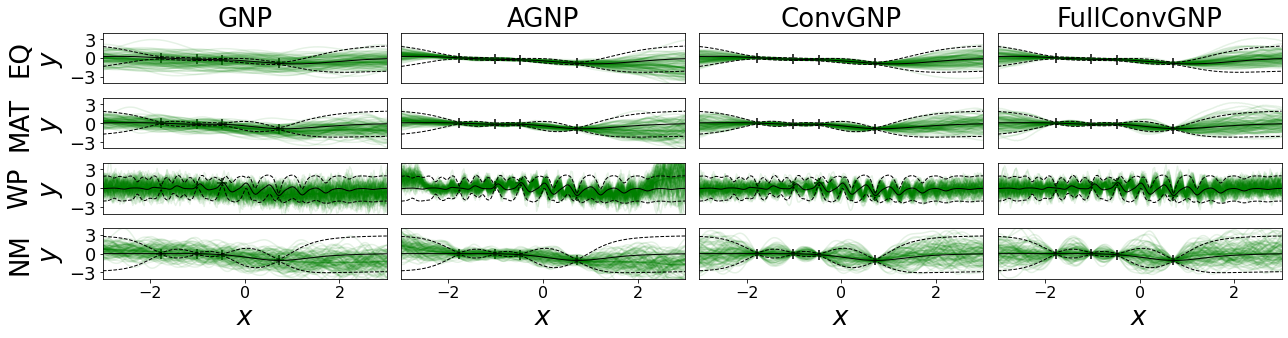

In [7]:
models = [('GNP', StandardGNP, 'gnp-kvv-0'),
          ('AGNP', StandardAGNP, 'agnp-kvv-0'),
          ('ConvGNP', StandardConvGNP, 'convgnp-kvv-0'),
          ('FullConvGNP', FullConvGNP, 'fcgnp-0')]

data_types = [('eq', eq_cov(lengthscale=1., coefficient=1., noise=1e-1), 'EQ'),
              ('matern', mat_cov(lengthscale=1., coefficient=1., noise=1e-1), 'MAT'),
              ('wp', wp_cov(period=0.5, lengthscale=1., coefficient=1., noise=1e-1), 'WP'),
              ('nm', nm_cov(lengthscale1=1.0, lengthscale2=0.5, coefficient=1., noise=1e-1), 'NM')]

levels = [np.linspace(-0.3, 1.2, 100),
          np.linspace(-0.3, 2.0, 100),
          np.linspace(-0.4, 1.5, 100),
          np.linspace(-0.4, 3.0, 100)]
    
plt.figure(figsize=(18, 1.2 * len(data_types)))

for j, (data_type, generator) in enumerate(zip(data_types, generators)):

    np.random.seed(2)
    torch.manual_seed(2)
        
    data = list(generator)[0]
    a = np.arange(4)
    idx = np.random.choice(np.arange(data['x'].shape[1]), size=(a.shape[0],), replace=False)
    mask = np.ones(data['x'].shape[1], dtype=bool)
    mask[idx] = False

    x_context = data['x'][:, ~mask, :]
    y_context = data['y'][:, ~mask, :]
    x_target = data['x'][:, mask, :]
    y_target = data['y'][:, mask, :]
    
    x_plot = torch.linspace(xmin, xmax, 200)[None, :, None]
    x_plot = x_plot.repeat(x_context.shape[0], 1, 1)
    
    for i, model_type in enumerate(models):
        
        plt.subplot(len(data_types), 4, j * len(models) + i + 1)

        path = f'./models/{data_type[0]}-{model_type[2]}'

        cov = KvvCov(num_basis_dim=num_basis_dim)
        noise = AddHomoNoise()

        if model_type[0] == 'FullConvGNP':
            model = model_type[1]()
        else:
            model = model_type[1](input_dim=1, covariance=cov, add_noise=noise)
            
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu'))['state_dict'])

        model_output = model(x_context, y_context, x_plot)
        mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]
        cov = cov[0]
        
        chol = np.linalg.cholesky(cov + 1e-5 * np.eye(cov.shape[0]))
        samples = mean[0, :, :] + chol @ np.random.normal(size=(cov.shape[0], 100))
        
        var = np.diag(cov)

        plt.plot(x_plot[0, :, 0], mean[0, :, 0], color='green', alpha=0.5)

        plt.plot(x_plot[0, :, 0], samples, color='green', alpha=0.1)
        
        plt.scatter(x_context[0, :, 0], y_context[0, :, 0], color='k', marker='+', s=100)
        
        exact_mean, exact_var = exact_gp_post(x_data=x_context[0, :],
                                              y_data=y_context[0, :],
                                              x_pred=x_plot[0, :],
                                              covariance=data_type[1])
        
        plt.plot(x_plot[0, :, 0], exact_mean, color='k', linewidth=1., alpha=1)
        plt.plot(x_plot[0, :, 0], exact_mean - 2 * exact_var ** 0.5, '--', color='k', linewidth=1., alpha=1)
        plt.plot(x_plot[0, :, 0], exact_mean + 2 * exact_var ** 0.5, '--', color='k', linewidth=1., alpha=1)
        
        plt.xticks(np.linspace(-2, 2, 3), fontsize=16)
        
        if i > 0:
            plt.yticks([])
        
        else:
            plt.yticks(np.linspace(-3, 3, 3), fontsize=18)
            plt.ylabel(f"{data_type[2]}" + "\n$y$", fontsize=26)
            
        if j == len(data_types) - 1:
            plt.xlabel('$x$', fontsize=26)
            
        if j == 0:
            plt.title(f'{model_type[0]}', fontsize=26)
            
        if j < len(data_types) - 1:
            plt.xticks([])
            
        plt.xlim([-3, 3])
        plt.ylim([-4, 4])
        
plt.tight_layout()
plt.savefig('plots/post-inter.pdf')
plt.show()